# Data Preprocessing of the House Prices Dataset

In [1]:
# pandas: handle the datasets in the pandas dataframe for data processing and analysis
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: apply high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

# matplotlib: standard library to create visualizations
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

# seaborn: advanced visualization library to create more advanced charts
import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

# turn off warnings for better reading in the Jupyter notebbok
pd.options.mode.chained_assignment = None  # default='warn'

# show all columns of the pandas dataframe in the jupyter console
pd.set_option('display.max_columns', None)

pandas version: 1.3.4
numpy version: 1.20.3
matplotlib version: 3.4.3
seaborn version: 0.11.2


In [42]:
# load training and test dataset
df_train = pd.read_csv('../01_rawdata/train.csv', index_col = "Id")
df_test = pd.read_csv('../01_rawdata/test.csv', index_col = "Id")

df_train.name = "df_train"
df_test.name = "df_test"

print("Number of rows in the training dataset: {}".format(df_train.shape[0]))
print("Number of columns in the training dataset: {}".format(df_train.shape[1]))
print(50*"-")
print("Number of rows in the test dataset: {}".format(df_test.shape[0]))
print("Number of columns in the test dataset: {}".format(df_test.shape[1]))

Number of rows in the training dataset: 1460
Number of columns in the training dataset: 80
--------------------------------------------------
Number of rows in the test dataset: 1459
Number of columns in the test dataset: 79


## Remove Missing Values
From the statistic report we already saw that there are missing values in the training and test dataset. With the following function you get a better overview of the missing values.
Before we fix or remove outliers we want to remove columns with a lot of missing values. Therefore we have fewer features that could have outliers.

In [43]:
def find_missing_values(df):
    """
    find missing values in the dataframe
    return the features with missing values, the total number of missing values and the percentage of missing values
    """
    total = df.isnull().sum().sort_values(ascending=False) # compute the total number of missing values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) # compute the percentage of missing values
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # add all information to one dataframe
    missing_data = missing_data[missing_data['Total']>0] # filter the dataframe to only the features with missing values
    return missing_data

In [45]:
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
df_test['Exterior1st'] = df_test['Exterior1st'].fillna('MetalSd')
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna('MetalSd')
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')
df_test['Functional'] = df_test['Functional'].fillna('Typ')
df_test['SaleType'] = df_test['SaleType'].fillna('WD')

df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['Electrical'] = df_train['Electrical'].fillna('SBrkr')

df_train_missing_values = find_missing_values(df_train)
df_test_missing_values = find_missing_values(df_test)

# drop features with missing values
df_train = df_train.drop(df_train_missing_values[df_train_missing_values.Percent > 0.15].index, axis=1)
df_test = df_test.drop(df_test_missing_values[df_test_missing_values.Percent > 0.15].index, axis=1)

In [46]:
df_train_missing_values[df_train_missing_values.Percent <= 0.15]

,Total,Percent
GarageQual,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342
BsmtQual,37,0.025342


In [47]:
df_test_missing_values[df_test_missing_values.Percent <= 0.15]

,Total,Percent
GarageCond,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461
GarageQual,78,0.053461
GarageType,76,0.052090
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
BsmtFinType2,42,0.028787


## Fix or Remove Outliers

In [51]:
# use isolation forest algorithm to find and delete outliers
from sklearn.ensemble import IsolationForest

col_train_numeric = list(df_train.drop("SalePrice", axis='columns').describe())
df_train_tmp = df_train.dropna(axis='index')

model=IsolationForest(n_estimators=100,max_samples='auto')
model.fit(df_train_tmp[col_train_numeric])

df_train_tmp['scores'] = model.decision_function(df_train_tmp[col_train_numeric])
df_train_tmp['anomaly_score'] = model.predict(df_train_tmp[col_train_numeric])

In [52]:
df_train = df_train.drop(
    list(df_train_tmp[df_train_tmp['anomaly_score']==-1][col_train_numeric].index),
    axis='index'
)

## Fix Missing Values

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

pd.options.mode.chained_assignment = None  # default='warn'

In [54]:
def imput_missing_values_KNN(df, column):
    # find the columns with missing values and store the column name as list
    cols_nan = df.columns[df.isna().any()].tolist()

    # remove out feature from the list that we want to predict
    cols_nan.remove(column)

    # drop all other features with missing values to that only missing values of column are in the dataset
    df_tmp = df.drop(cols_nan, axis="columns")
    
    # the test data are the samples with missing values
    df_test = df_tmp.loc[(df[column].isnull())]  # null samples for feature
    df_train = df_tmp.loc[(df[column].notnull())]  # known samples for feature

    df_train_y = df_train[[column]]
    df_train.drop(columns=[column], inplace=True)
    df_train.dropna(axis='columns', inplace=True) # drop the columns that contain missing values

    df_test_x = df_test[df_train.columns] # the test dataset can only contain features from the training


    if df[column].dtypes not in ('int64','float64'):
        # categoric lables have to be encoded with the label encoder
        le = LabelEncoder()
        df_train_y = le.fit_transform(df_train_y)
    
        # use the KNN Classifier algorithm to fill the missing values
        knr = KNeighborsClassifier(n_neighbors=5)
    
    else:
        # use the KNN regression algorithm to fill the missing values
        knr = KNeighborsRegressor(n_neighbors=5)
    

    # define the categoric and numeric features for the column transformation
    categorical_features = list(df_train.describe(include="O"))
    numeric_features = list(df_train.describe())

    col_transform = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                ('num', StandardScaler(), numeric_features)
            ]
        )

    # define pipeline
    pipeline = Pipeline(steps=[
        ('columnprep', col_transform),
        ('classification', knr)
    ])
    
    
    # train the KNN Classifier
    pipeline.fit(df_train, df_train_y)
    print("Accuracy score - {}: {:.2f}".format(column, pipeline.score(df_train, df_train_y)))

    # predict the missing values
    df_test_y = pipeline.predict(df_test_x)

    if df[column].dtypes not in ('int64','float64'):
        # retransform the missing values into labels
        df_test_y = le.inverse_transform(df_test_y)

    # fill the missing values in the original dataset with the predicted values
    df.loc[(df[column].isnull()), column] = df_test_y
    
    return df

In [55]:
for column in find_missing_values(df_train).index:
    df_train = imput_missing_values_KNN(df_train, column)

Accuracy score - GarageType: 0.85
Accuracy score - GarageYrBlt: 0.83
Accuracy score - GarageFinish: 0.78
Accuracy score - GarageQual: 0.96
Accuracy score - GarageCond: 0.97
Accuracy score - BsmtFinType2: 0.92
Accuracy score - BsmtExposure: 0.76
Accuracy score - BsmtFinType1: 0.70
Accuracy score - BsmtCond: 0.93
Accuracy score - BsmtQual: 0.86
Accuracy score - MasVnrArea: 0.59


In [56]:
df_train_missing_values = find_missing_values(df_train)
df_train_missing_values

,Total,Percent


In [57]:
for column in find_missing_values(df_test).index:
    df_test = imput_missing_values_KNN(df_test, column)

Accuracy score - GarageYrBlt: 0.78
Accuracy score - GarageFinish: 0.75
Accuracy score - GarageCond: 0.96
Accuracy score - GarageQual: 0.94
Accuracy score - GarageType: 0.84
Accuracy score - BsmtCond: 0.92
Accuracy score - BsmtQual: 0.85
Accuracy score - BsmtExposure: 0.78
Accuracy score - BsmtFinType1: 0.62
Accuracy score - BsmtFinType2: 0.88
Accuracy score - MasVnrArea: 0.64
Accuracy score - BsmtFullBath: 0.46
Accuracy score - BsmtHalfBath: 0.35
Accuracy score - Utilities: 1.00
Accuracy score - GarageArea: 0.62
Accuracy score - GarageCars: 0.77
Accuracy score - KitchenQual: 0.84
Accuracy score - BsmtFinSF1: 0.71
Accuracy score - BsmtFinSF2: 0.46
Accuracy score - BsmtUnfSF: 0.72
Accuracy score - TotalBsmtSF: 0.80


In [58]:
df_test_missing_values = find_missing_values(df_test)
df_test_missing_values

,Total,Percent


## Feature Transformation

### Create new Features

In [59]:
df_train['YrBltAndRemod'] = df_train['YearBuilt'] + df_train['YearRemodAdd']
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train['Total_sqr_footage'] = (df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] + df_train['1stFlrSF'] + df_train['2ndFlrSF'])
df_train['Total_Bathrooms'] = (df_train['FullBath'] + (0.5 * df_train['HalfBath']) + df_train['BsmtFullBath'] + (0.5 * df_train['BsmtHalfBath']))
df_train['Total_porch_sf'] = (df_train['OpenPorchSF'] + df_train['3SsnPorch'] + df_train['EnclosedPorch'] + df_train['ScreenPorch'] + df_train['WoodDeckSF'])

df_train['haspool'] = df_train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_train['has2ndfloor'] = df_train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasgarage'] = df_train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasbsmt'] = df_train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasfireplace'] = df_train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


df_test['YrBltAndRemod'] = df_test['YearBuilt'] + df_test['YearRemodAdd']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['Total_sqr_footage'] = (df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] + df_test['1stFlrSF'] + df_test['2ndFlrSF'])
df_test['Total_Bathrooms'] = (df_test['FullBath'] + (0.5 * df_test['HalfBath']) + df_test['BsmtFullBath'] + (0.5 * df_test['BsmtHalfBath']))
df_test['Total_porch_sf'] = (df_test['OpenPorchSF'] + df_test['3SsnPorch'] + df_test['EnclosedPorch'] + df_test['ScreenPorch'] + df_test['WoodDeckSF'])

df_test['haspool'] = df_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_test['has2ndfloor'] = df_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_test['hasgarage'] = df_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_test['hasbsmt'] = df_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_test['hasfireplace'] = df_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Transform Skewed Features

In [60]:
from scipy.stats import skew
def compute_skewed_features(df):
    """
    compute the skewness of all numeric features and the total number of unique values
    return only the features that have a relevant skewness
    """
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = pd.DataFrame(index=numeric_feats, columns=['skewness', 'skewness_no_zero', 'unique_values'])
    skewed_feats['skewness'] = df[numeric_feats].apply(lambda x: skew(x))
    skewed_feats['skewness_no_zero'] = df[numeric_feats].apply(lambda x: skew(x[x != 0]))
    skewed_feats['unique_values'] = df.nunique()
    skewed_feats = skewed_feats[(skewed_feats['unique_values'] >= 10) & ((skewed_feats['skewness'] > 1) | (skewed_feats['skewness'] < -1))]

    return skewed_feats

skewed_feats = compute_skewed_features(df_train)
skewed_feats.sort_values(by=["skewness", "unique_values"], ascending=False)

,skewness,skewness_no_zero,unique_values
MiscVal,30.312888,5.889631,18
3SsnPorch,10.074207,1.205196,20
LowQualFinSF,9.934124,-0.127490,20
LotArea,7.081737,7.081737,1027
BsmtFinSF2,4.400912,1.042883,133
ScreenPorch,4.096671,0.751836,66
EnclosedPorch,2.835052,0.128399,112
MasVnrArea,2.586153,2.130190,316
OpenPorchSF,2.019373,1.853181,189
WoodDeckSF,1.438807,1.454977,260


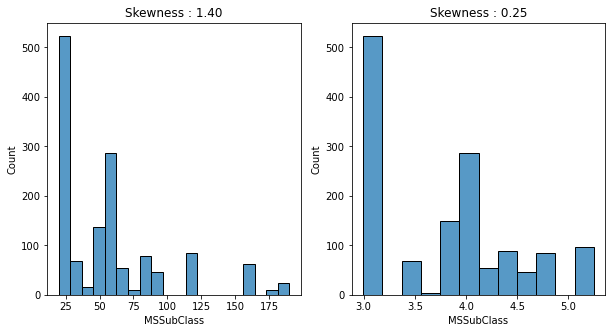

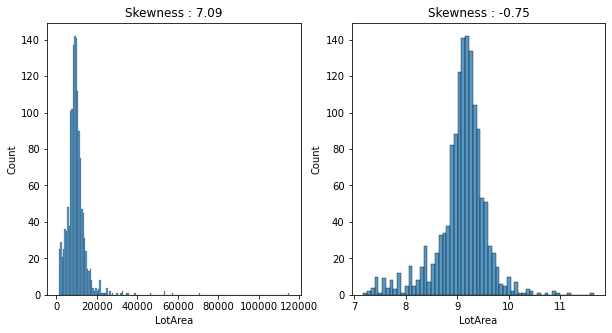

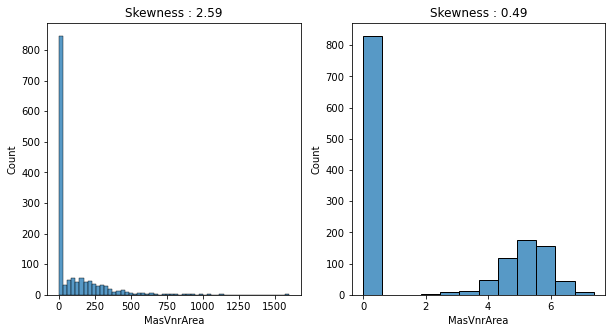

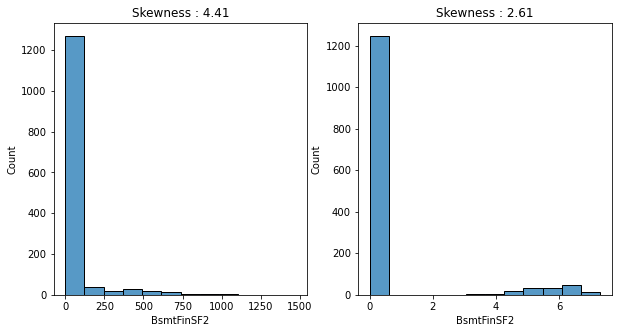

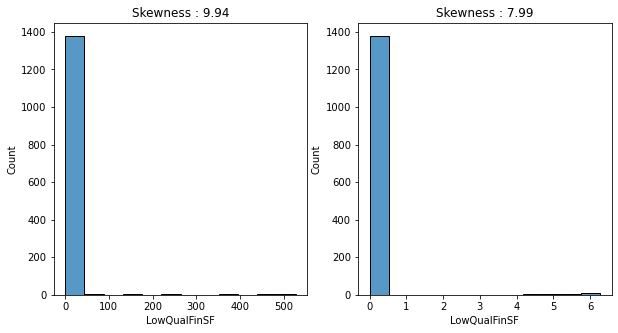

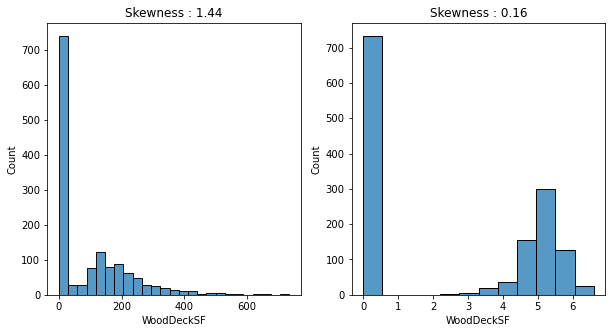

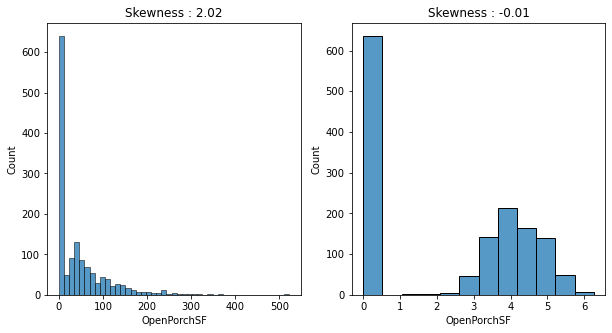

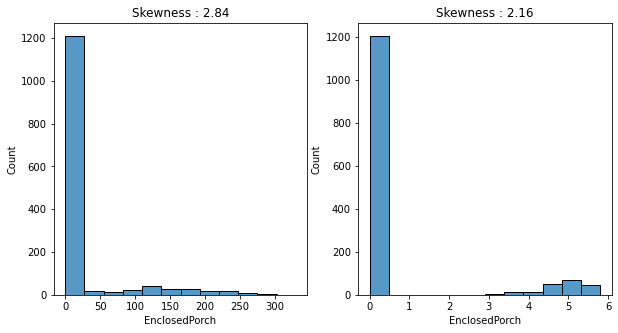

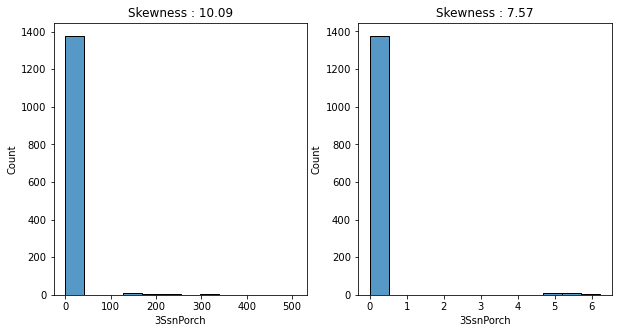

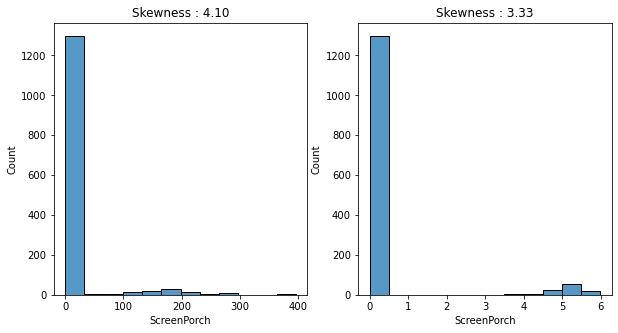

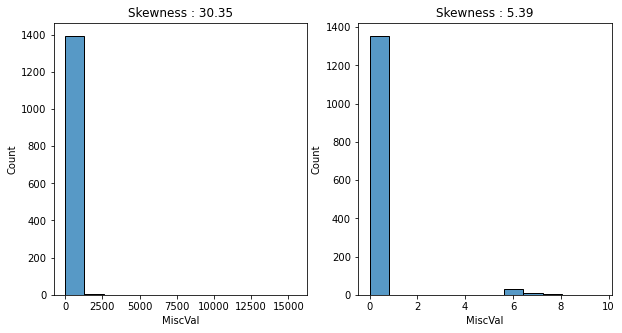

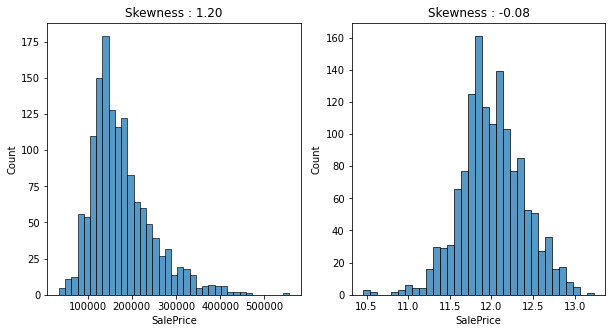

In [61]:
import scipy.stats as stats

skewed_features = list(skewed_feats.index)
#skewed_features.remove('SalePrice')

for col in skewed_features:
    # plot the influence of the skewed features on the target variable
    # jointplot of SalePrice with itself is not possible
    if col != "SalePrice":
        graph = sns.jointplot(data=df_train, x=col, y="SalePrice", kind="reg")
        df_ = df_train[[col, "SalePrice"]].dropna(axis='index')
        r, p = stats.pearsonr(df_[col], df_["SalePrice"])
        phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
        graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

        graph.figure.set_size_inches(18.5, 10.5)
        graph.savefig("influence_numerical_features/{}.png".format(col))
        plt.close()
    
    # show the skewdness of each feature before and after a possible log transformation
    col_tmp = df_train[col].apply(np.log)
    col_tmp[np.isneginf(col_tmp)]=0
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sns.histplot(df_train[col], ax=ax1)
    sns.histplot(col_tmp, ax=ax2)
    ax1.title.set_text("Skewness : %.2f"%(df_train[col].skew()))
    ax2.title.set_text("Skewness : %.2f"%(col_tmp.skew()))
    fig.savefig("skewness_features/{}.png".format(col))
    plt.show()
    plt.close()

After visualizing the columns that are skewed we transform some of the columns. Most columns are calculated as skewed because they have a lot of 0 values.
- LotArea (log transform)
- MasVnrArea (do nothing)
- MiscVal (delete value > 14000)

In [62]:
df_train = df_train[df_train["MiscVal"] < 14000]

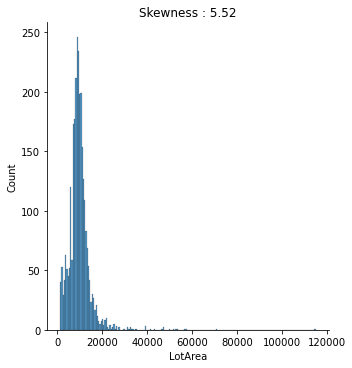

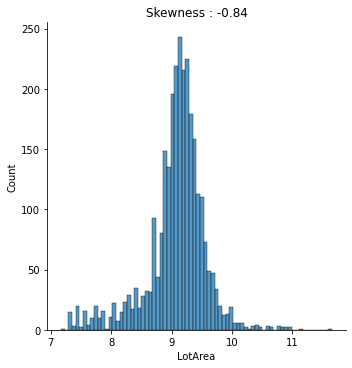

In [63]:
for feature in ['LotArea']:
    
    # view the distribution of Fare after the log transformation with the skewness
    df_merge = pd.concat([df_train, df_test])
    g = sns.displot(df_merge[feature])
    plt.title("Skewness : %.2f"%(df_merge[feature].skew()))
    plt.show()
    
    df_train[feature] = df_train[feature].apply(np.log)
    df_test[feature] = df_test[feature].apply(np.log)

    # the not transformed data that contains 0
    # after the transformation we have -inf values that have to be replaced by 0
    df_train[feature][np.isneginf(df_train[feature])]=0
    df_test[feature][np.isneginf(df_test[feature])]=0

    # view the distribution of Fare after the log transformation with the skewness
    df_merge = pd.concat([df_train, df_test])
    g = sns.displot(df_merge[feature])
    plt.title("Skewness : %.2f"%(df_merge[feature].skew()))
    plt.show()

## Transform Categoric Features to Numeric

In [64]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_vars = df_train.dtypes[df_train.dtypes == "object"].index

In [65]:
ohe_train = pd.DataFrame(enc.fit_transform(df_train[cat_vars]), columns=enc.get_feature_names())
print("df_train old shape: " + str(df_train.shape))
print("ohe_train old shape: " + str(ohe_train.shape))

df_train.reset_index(drop=True, inplace=True)
df_train = df_train.drop(cat_vars, axis=1)

ohe_train.reset_index(drop=True, inplace=True)

df_train = pd.concat([df_train, ohe_train], axis=1)
print("df_train new shape: " + str(df_train.shape))

df_train old shape: (1399, 84)
ohe_train old shape: (1399, 230)
df_train new shape: (1399, 276)


In [66]:
ohe_test = pd.DataFrame(enc.transform(df_test[cat_vars]), columns=enc.get_feature_names())
print("df_test old shape: " + str(df_test.shape))
print("ohe_test old shape: " + str(ohe_test.shape))

df_test.reset_index(drop=True, inplace=True)
df_test = df_test.drop(cat_vars, axis=1)

ohe_test.reset_index(drop=True, inplace=True)

df_test = pd.concat([df_test, ohe_test], axis=1)
print("df_test new shape: " + str(df_test.shape))

df_test old shape: (1459, 83)
ohe_test old shape: (1459, 230)
df_test new shape: (1459, 275)


## Feature Selection

### Drop Features with Low Variance

In [67]:
from sklearn.feature_selection import VarianceThreshold

# remove all features that are either one or zero in more than 95% of the samples
sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
sel_features = list(df_train)

# remove the label from the list of columns
sel_features.remove("SalePrice")

# fit the VarianceThreshold object to the training data
sel.fit(df_train[sel_features])

# get the column names after the variance threshold reduction
sel_features_reduced = [sel_features[i] for i in sel.get_support(indices=True)]

# create the training and test dataset by transform the datasets to the variance threshold object
df_train_ = pd.DataFrame(sel.transform(df_train[sel_features]), columns=sel_features_reduced)
# dont forget to join the label back to the training data
df_train = pd.concat([df_train_, df_train["SalePrice"]], axis=1)

# apply the result for the training data also to the test dataset
df_test = pd.DataFrame(sel.transform(df_test[sel_features]), columns=sel_features_reduced)

print("df_train shape: " + str(df_train.shape))
print("df_test shape: " + str(df_test.shape))

df_train shape: (1399, 129)
df_test shape: (1459, 128)


### Drop Features with a High Correlation
If two or more features have a high correlation, only one feature add information to the machine learning algorithm. Multiple features with a high correlation can lead to overfitting, like coping a feature 10 times does not add any useful information to the dataset. Therefore we calculate the Pearson correlation between each feature.

In [68]:
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation higher than 0.9 or lower -0.9
to_drop = [column for column in upper.columns if any((upper[column] > 0.9) | (upper[column] < -0.9))]

for element in to_drop:
    column_list = list(df_train.columns[np.where(
        (df_train.corrwith(df_train[element]) > 0.9) |
        (df_train.corrwith(df_train[element]) < -0.9))])
    column_list.remove(element)
    for column in column_list:
        print(str(element) + " <-> " + str(column) + ": " + str(df_train[element].corr(df_train[column])))

C:\Users\chris\AppData\Local\Temp/ipykernel_2176/1501349958.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


YrBltAndRemod <-> YearBuilt: 0.931133217134089
has2ndfloor <-> 2ndFlrSF: 0.9254386283667169
hasfireplace <-> Fireplaces: 0.9080703605789977
x2_Reg <-> x2_IR1: -0.9357232956864744
x12_Hip <-> x12_Gable: -0.9390450276408472
x15_MetalSd <-> x14_MetalSd: 0.9749319413069895
x15_VinylSd <-> x14_VinylSd: 0.9782556782078171
x17_TA <-> x17_Gd: -0.9263809639086735
x27_Y <-> x27_N: -1.0
x37_Partial <-> x36_New: 0.9858323627904887


In [69]:
df_train.drop(['YrBltAndRemod', '2ndFlrSF', 'Fireplaces', 'x2_Reg', 'x12_Hip', 'x15_MetalSd', 'x15_VinylSd', 'x17_TA', 'x27_Y', 'x37_Partial'], axis=1, inplace=True)
df_test.drop(['YrBltAndRemod', '2ndFlrSF', 'Fireplaces', 'x2_Reg', 'x12_Hip', 'x15_MetalSd', 'x15_VinylSd', 'x17_TA', 'x27_Y', 'x37_Partial'], axis=1, inplace=True)

print("df_train shape: " + str(df_train.shape))
print("df_test shape: " + str(df_test.shape))

df_train shape: (1399, 119)
df_test shape: (1459, 118)


In [70]:
# save prepared dataset as pickle file
df_train.to_pickle('df_train_prepared.pkl')
df_test.to_pickle('df_test_prepared.pkl')